In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
plt.rcParams['figure.figsize']=(20,10)

In [3]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")
	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

In [15]:
def calc_transform_matrix(pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    return (M,maxWidth,maxHeight)

In [28]:
def four_point_transform(image, M,maxWidth,maxHeight):
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped

In [111]:
def compute_point_perspective_transformation(matrix,list_downoids):
	""" Apply the perspective transformation to every ground point which have been detected on the main frame.
	@ matrix : the 3x3 matrix 
	@ list_downoids : list that contains the points to transform
	return : list containing all the new points
	"""
	# Compute the new coordinates of our points
	list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
	transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
	# Loop over the points and add them to the list that will be returned
	transformed_points_list = list()
	for i in range(0,transformed_points.shape[0]):
		transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
	return transformed_points_list

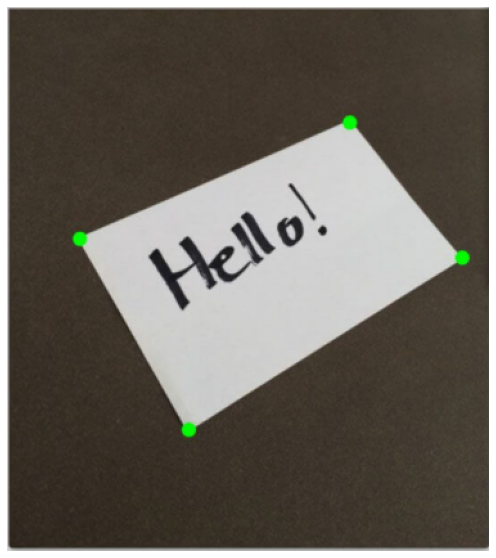

In [21]:
img = cv2.imread('data/paper.png')
plt.axis('off')
plt.imshow(img[:,:,::-1])
plt.show()

In [144]:
pts=np.array([(57,179),(266,89),(354,194),(141,327)])
#pts = np.array([(348,133),(755,242),(495,470),(76,292)])

In [145]:
M,W,H = calc_transform_matrix(pts)

In [146]:
M,W,H

(array([[ 9.47187964e-01, -5.37593168e-01,  4.22394632e+01],
        [ 5.56657842e-01,  1.29268321e+00, -2.63119792e+02],
        [-5.52945103e-04,  1.48838287e-03,  1.00000000e+00]]),
 251,
 170)

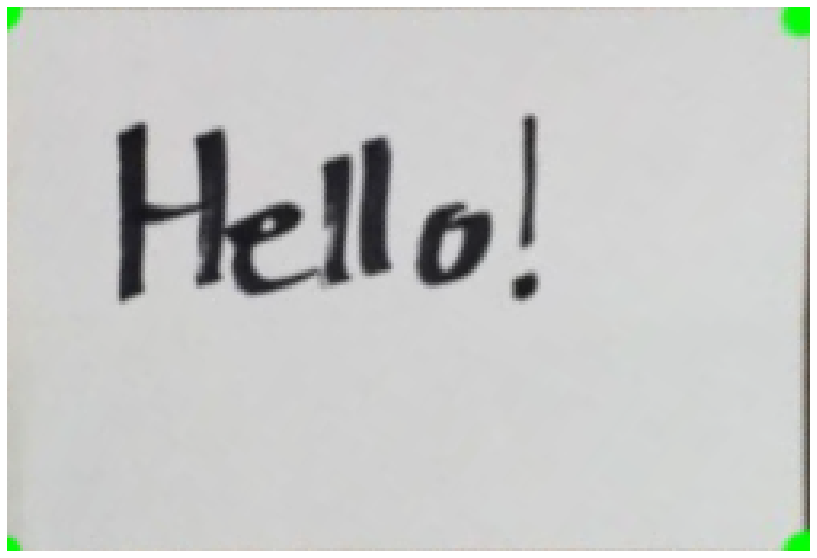

In [29]:
warped = four_point_transform(img,M,W,H)
plt.axis('off')
plt.imshow(warped[:,:,::-1])
plt.show()

In [58]:
cvNet = cv2.dnn.readNetFromTensorflow('model/faster_rcnn_inception_v2_coco_2018_01_28.pb','model/faster_rcnn_inception_v2_coco_2018_01_28.pbtxt')
#cvNet = cv2.dnn.readNet('model/MobileNetSSD_deploy.caffemodel','model/MobileNetSSD_deploy.prototxt')

In [51]:
video = cv2.VideoCapture('data/PETS2009.avi')

In [86]:
status,frame = video.read()

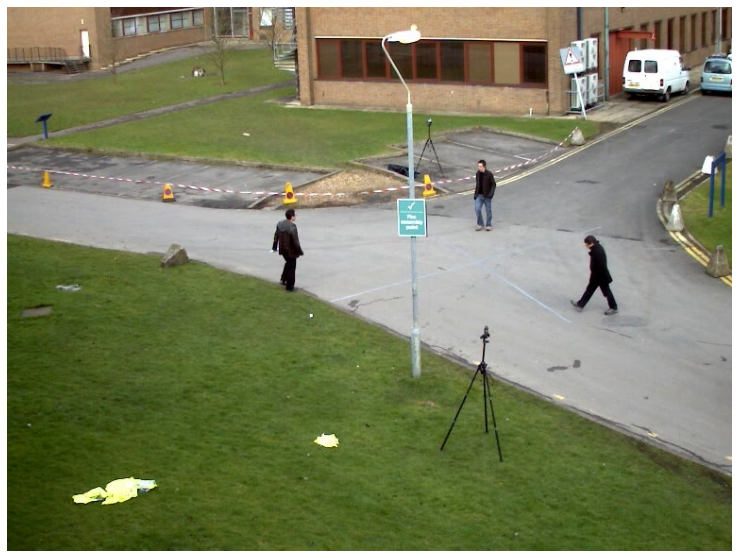

In [90]:
plt.axis('off')
plt.imshow(frame[:,:,::-1])
plt.show()

In [198]:
frame.shape

(576, 768, 3)

In [93]:
cv2.imwrite('data/output.jpg',frame)

True

In [179]:
pts = np.array([(402,138),(757,290),(570,470),(174,265)],dtype='float32')

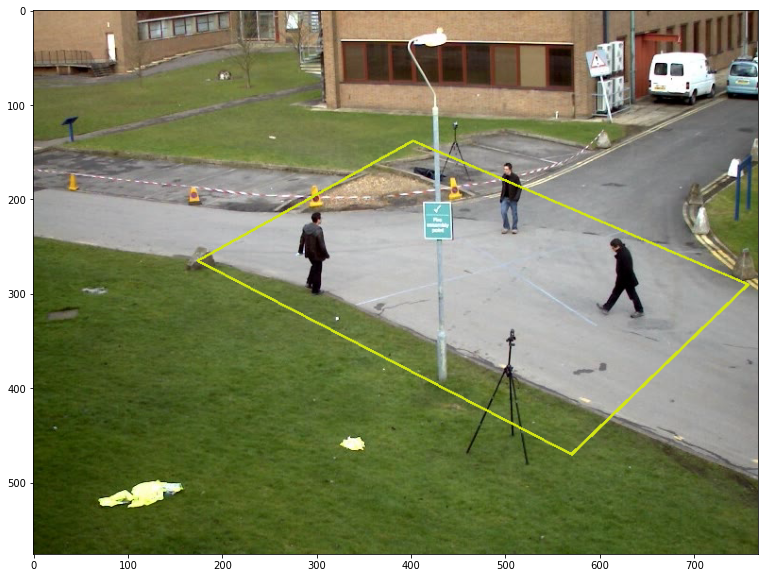

In [193]:
img = frame.copy()
cv2.polylines(img,np.int32([pts]),True,(23, 230, 210), thickness=2)
plt.imshow(img[:,:,::-1])
plt.show()

In [194]:
maxWidth,maxHeight = 80*3,60*3
dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")
# compute the perspective transform matrix and then apply it
T_M = cv2.getPerspectiveTransform(pts, dst)
list_downoids = [(415,203),(443,242)]
transformed_pts = compute_point_perspective_transformation(T_M,list_downoids)

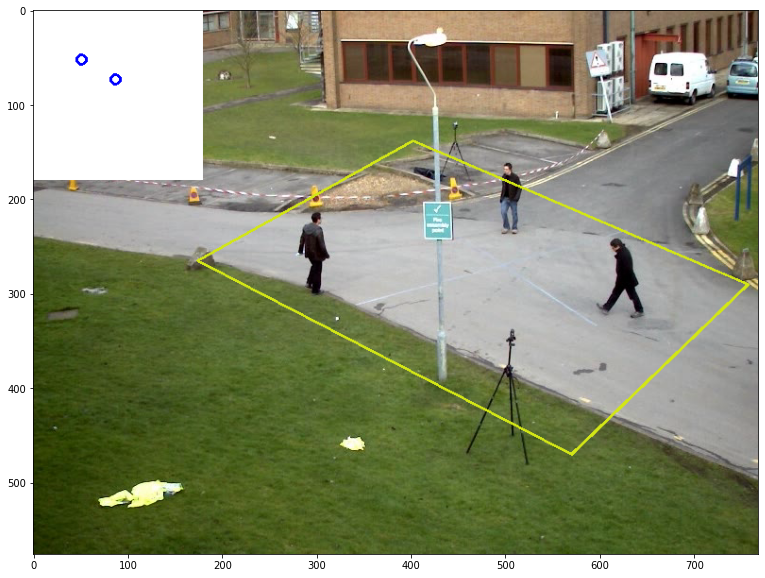

In [196]:
img[:maxHeight,:maxHeight,:]=255
for pt in transformed_pts:
    cv2.circle(img,(int(pt[0]),int(pt[1])),5,(255,0,0),2)
    #print(pt)
plt.imshow(img[:,:,::-1])
plt.show()    

In [199]:
video.release()